# Exploration of Dimension Reduction
<span style="font-weight:bold; font-size:17pt; color:#666666;">XGBoost for feature selection</span>
<hr>

This notebook is for EDA, feature extraction, engineering and the subsequent evaluation of XGBoost as a dimension reduction technique.

It assumes the data are in a sub-directory of the **/data** folder. I've already added entries to the _.gitignore_ file so that they won't be committed to the repository. Note that this file should be updated for new versions of the data.

See the [data readme in the Gitbug repository](https://github.com/BrianDavisMath/FDA-COVID19/tree/master/data) for more details.

<hr>

In [ ]:
%pylab inline
%autosave 25

import h5py
import random
import pandas as pd

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

## Data location

Change this when you get a new data set.

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

## Experiment 1

XGBoost for features extraction.

* obtain features using the **greg-features.ipynb** notebobook
* sample data using **_centroid_sampling.ipynb_** noteboob
* remove highly correlated columns using **dim-red-via-correlation.ipynb**
* run basic model multiple times to determine a candidate set for features
* make sure the most important features do not drastically change across each model trained
* reduce data set to use the subset of candidate features
* determine number of epochs for training XGBoost
* grid/random search parameter space to finie tune parameters
* evaluate the mode w.r.t. weighted F1 score (see greg-train-validation-split-eval.ipynb for details)

<hr>

## Load the data from sampled_data.h5

In [3]:
store = pd.HDFStore(data_loc + 'training_sampled_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 19,632, columns: 13,851


# XGBoost

reference material:

* [An End-to-End Guide to Understand the Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/)
* [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html)
* [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
*[Python's Xgoost: ValueError('feature_names may not contain \[, \] or \<')](https://stackoverflow.com/questions/48645846/pythons-xgoost-valueerrorfeature-names-may-not-contain-or/50633571)
* [Fine-tuning XGBoost in Python like a boss](https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e)

In [5]:
Y = df_features['activity'].values
X = df_features.drop(['activity', 'cid', 'pid'], axis=1)

### Fix column names

#### XGBoost does not like <>, [] and , in column names

..change the column names to their ordinal numbers.

In [6]:
X.columns = list(range(0, len(X.columns)))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,13838,13839,13840,13841,13842,13843,13844,13845,13846,13847
0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,...,0,0,0,0,0,0,0,0,0,0
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,...,0,0,0,0,0,0,0,0,0,0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,...,0,0,0,0,0,0,0,0,0,0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00000,-1.0,...,0,0,0,0,0,0,0,0,0,0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.95519,-1.0,...,0,0,0,0,0,0,0,0,0,0


## XGBoost parameter tuning

Play around with fitting a model and see if we can narrow down the parameter search space for subsequent fine tuning.

reference material:

* [Avoid Overfitting By Early Stopping With XGBoost In Python](https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/)
* [How to Tune the Number and Size of Decision Trees with XGBoost in Python](https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/)
* [A Gentle Introduction to Early Stopping to Avoid Overtraining Neural Networks](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/)
* [Stackoverflow: Training Error is Lower than Testing error in a Random Forest Model](https://stackoverflow.com/questions/53420692/training-error-is-lower-than-testing-error-in-a-random-forest-model)

In [3]:
# split data into train and test sets
def train(random_state=42, n_estimators=600, xgb=None):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=random_state)

    # fit model to training data
    eval_set = [(X_train, y_train), (X_test, y_test)]

    if xgb is None:
        xgb = XGBClassifier(learning_rate=0.02, n_estimators=n_estimators, objective='binary:logistic',
                        silent=True, nthread=1)

    xgb.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False, early_stopping_rounds=50)

    # make predictions for test data
    y_pred = xgb.predict(X_test)
    predictions = [round(value) for value in y_pred]

    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    # retrieve performance metrics
    results = xgb.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()
    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()
    return xgb

### run twice to compare the most important features

We do not want to see different features every time.

Accuracy: 82.13%


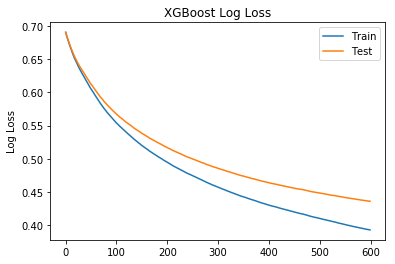

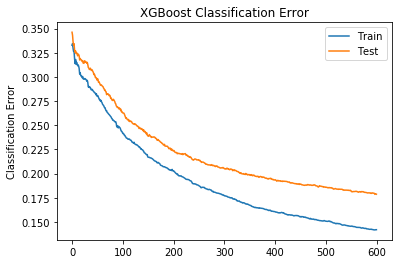

Accuracy: 81.48%


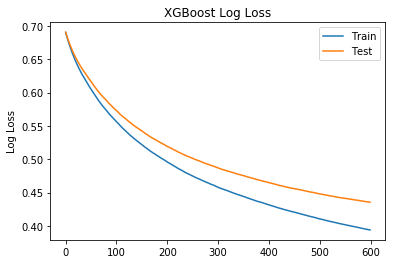

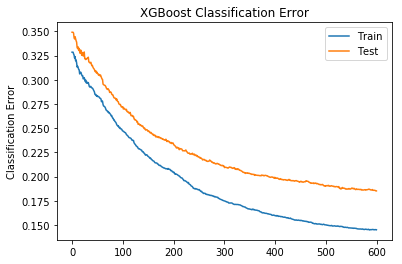

In [8]:
xgb = train()
xgb2 = train(random_state=7)

### Find the most important features

reference material:

* [The Multiple faces of ‘Feature importance’ in XGBoost](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7)

In [4]:
# Get importance as information gain (the improvement in accuracy brought by a feature).
def get_features(model):
    gain_importance = model.get_booster().get_score(importance_type="gain")
    return [int(key) for key in gain_importance.keys()]

In [61]:
xgb_features = get_features(xgb)
print('number of most important features: {:,}'.format(len(xgb_features)))

xgb2_features = get_features(xgb2)
print('number of most important features: {:,}'.format(len(xgb2_features)))

number of most important features: 740


### How many important features in common?

In [14]:
common_features = set(xgb_features).intersection(set(xgb2_features))
print('number of important features in common: {:,}'.format(len(common_features)))

number of important features in common: 450


### Save new features to file

In [63]:
top_feature_cols = df_features.drop(['activity', 'cid', 'pid'], axis=1).columns.values[xgb_features]

features = ['activity', 'cid', 'pid'] + list(top_feature_cols)
df_to_save = df_features[features]
print(df_to_save.shape)
df_to_save.head()

(19632, 743)


,activity,cid,pid,IDM_y,YN*,EEE,NRS_y,IDA,C-027,[G2.1.1.176],...,Mi,*NL,LOC,ASC,IS*,[G2.1.1.218],[G5.2.2.38],ARR_y,RLL,KG*
0,1,204106,Q9UP65,10.043,-1.0,-1.000000,5,-1.0,0.0,0.370370,...,1.107,-1.000000,0.623,-1.0,-1.0,0.185185,0.033679,0.618,-1.0,5.264419
1,0,204106,P47712,10.043,-1.0,3.704249,5,-1.0,0.0,0.267380,...,1.107,-1.000000,0.623,-1.0,-1.0,0.401070,0.033101,0.618,-1.0,3.736527
3,1,10290302,P00403,10.047,-1.0,-1.000000,5,-1.0,0.0,0.442478,...,1.110,-1.000000,0.623,-1.0,-1.0,0.000000,0.033883,0.618,-1.0,-1.000000
4,1,10290302,P00395,10.047,-1.0,-1.000000,5,-1.0,0.0,0.195312,...,1.110,3.208557,0.623,-1.0,-1.0,0.781250,0.035034,0.618,-1.0,-1.000000
7,0,46938678,O15528,8.411,-1.0,-1.000000,2,-1.0,0.0,0.000000,...,1.131,-1.000000,1.500,-1.0,-1.0,0.000000,0.034528,0.000,-1.0,-1.000000


In [17]:
# save to a new file
store = pd.HDFStore(data_loc + 'xgboost_features_data.h5')
store['df'] = df_to_save
store.close()

### Grid search on the reduced feature set to find number of epochs (n_estimators)

In [18]:
Y = df_to_save['activity'].values
X = df_to_save.drop(['activity', 'cid', 'pid'], axis=1)

X.columns = list(range(0, len(X.columns)))
X.head()

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,-1.0,8.863,10.043,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.025,1.011,1.107,0,0,0,0,0
1,-1.0,8.863,10.043,95980.0,-1.0,-1.0,4.641,3.357792,-1.0,-1.0,...,0.0,0,-0.025,1.011,1.107,0,0,0,0,0
3,-1.0,8.863,10.047,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.051,0.995,1.110,1,0,0,0,0
4,-1.0,8.863,10.047,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.051,0.995,1.110,1,0,0,0,0
7,-1.0,7.452,8.411,17198.0,-1.0,-1.0,4.080,-1.000000,-1.0,-1.0,...,0.0,0,-0.118,0.974,1.131,0,0,0,0,0


In [ ]:
def n_est_grid_search(X, Y):
    xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic', silent=True, nthread=1)

    n_estimators = range(1000, 2200, 200) # try different numbers of epochs

    print('set of n_estimators to test: {}'.format([x for x in n_estimators]))

    param_grid = dict(n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=7)
    grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, Y)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    pyplot.errorbar(n_estimators, means, yerr=stds)
    pyplot.title("XGBoost n_estimators vs Log Loss")
    pyplot.xlabel('n_estimators')
    pyplot.ylabel('Log Loss')
    pyplot.savefig('n_estimators.png')

In [ ]:
n_est_grid_search(X, Y)

### Test training with new set of estimators to see if it overfits more

Accuracy: 84.84%


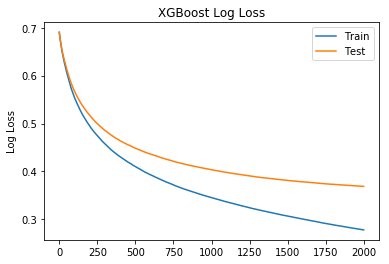

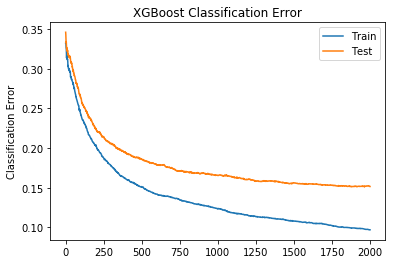

In [23]:
xgb3 = train(random_state=42, n_estimators=2000)

## Randomized hyperparameter space search

Now we have an idea about the number of epochs to use lets carry out a parameter search to refine the other parameters.

reference material:

* [Kaggle: Hyperparameter Grid Search with XGBoost](https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost)
* [Hi I’m Gamma. What can I do for you?](https://medium.com/data-design/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6)

In [27]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.1, 0.2, 0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 7]
        }


xgb4 = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:logistic',
                    silent=True, nthread=1)


folds = 3
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(X,Y), 
    verbose=3, 
    random_state=1001)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, Y)
timer(start_time) # timing ends here for "start_time" variable

random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  3.9min finished



 Time taken: 0 hours 4 minutes and 47.7 seconds.


{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 5,
 'colsample_bytree': 0.8}

### Fit best model against test set and calculated weighted F1 score

#### (1) train

In [7]:
# load features
store = pd.HDFStore(data_loc + 'xgboost_features_data.h5')
df_subset_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_subset_features), len(df_subset_features.columns)))

Y = df_subset_features['activity'].values
X = df_subset_features.drop(['activity', 'cid', 'pid'], axis=1)
X.columns = list(range(0, len(X.columns)))

X.head()

rows: 19,632, columns: 724


,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,-1.0,8.863,10.043,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.025,1.011,1.107,0,0,0,0,0
1,-1.0,8.863,10.043,95980.0,-1.0,-1.0,4.641,3.357792,-1.0,-1.0,...,0.0,0,-0.025,1.011,1.107,0,0,0,0,0
3,-1.0,8.863,10.047,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.051,0.995,1.110,1,0,0,0,0
4,-1.0,8.863,10.047,95980.0,-1.0,-1.0,4.641,-1.000000,-1.0,-1.0,...,0.0,0,-0.051,0.995,1.110,1,0,0,0,0
7,-1.0,7.452,8.411,17198.0,-1.0,-1.0,4.080,-1.000000,-1.0,-1.0,...,0.0,0,-0.118,0.974,1.131,0,0,0,0,0


Accuracy: 83.95%


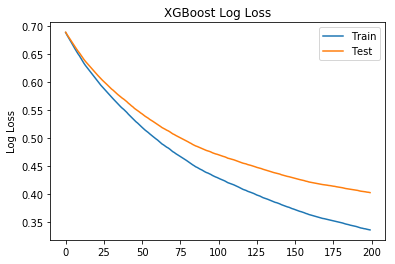

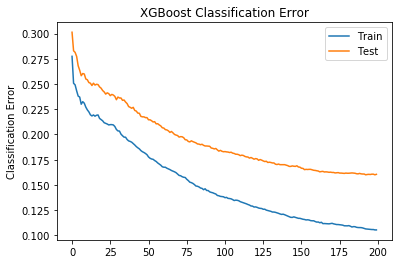

In [11]:
xgb5 = XGBClassifier(learning_rate=0.02, 
                    n_estimators=200, 
                    objective='binary:logistic',
                    silent=True, nthread=1,
                    subsample=0.6,
                    min_child_weight=1,
                    max_depth=6,
                    gamma=5,
                    colsample_bytree=0.8)

xgb6 = train(random_state=42, xgb=xgb5)

#### save the model

In [12]:
joblib.dump(xgb6, data_loc + 'xgboost_1.mdl')

['../data/FDA-COVID19_files_v1.0/xgboost_1.mdl']

#### load the model from file

In [5]:
xgb6 = joblib.load(data_loc + 'xgboost_1.mdl')

#### (2) Load test data

In [8]:
store = pd.HDFStore(data_loc + 'validation_features.h5')
df_test_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

# Take only the reduced set of columns.
df_test_features = df_test_features[df_subset_features.columns.tolist()]

print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

rows: 19,240, columns: 17,077
rows: 19,240, columns: 724


#### Check accuracy, precision and recall

In [9]:
X_test = df_test_features.drop(['cid', 'pid', 'activity'], axis=1)
y_test = df_test_features['activity'].values

X_test.columns = list(range(0, len(X_test.columns)))

# make predictions for test data
y_pred = xgb6.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.29%


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print("Accuracy = {:0.2f}%".format(sum(diag(cm))/sum(cm)*100))
print("Precision = {:0.2f}%".format(cm[1][1]/sum(cm[:, 1])*100))
print("Recall = {:0.2f}%".format(cm[1][1]/sum(cm[1, :])*100))

Accuracy = 59.29%
Precision = 38.33%
Recall = 76.94%


### Obtain the weighted F1 score

In [11]:
from sklearn.neighbors import NearestNeighbors

def get_validation_weights(training_features_active, training_features_inactive,
                           validation_features_active, validation_features_inactive):
    active_nbrs = NearestNeighbors(n_neighbors=1).fit(training_features_active)
    inactive_nbrs = NearestNeighbors(n_neighbors=1).fit(training_features_inactive)
    act_act_distances, _ = active_nbrs.kneighbors(validation_features_active)
    inact_act_distances, _ = active_nbrs.kneighbors(validation_features_inactive)
    act_inact_distances, _ = inactive_nbrs.kneighbors(validation_features_active)
    inact_inact_distances, _ = inactive_nbrs.kneighbors(validation_features_inactive)
    active_scores = act_act_distances / act_inact_distances
    active_weights = (1 + np.argsort(np.argsort(active_scores.flatten()))) / len(active_scores)
    inactive_scores = inact_inact_distances / inact_act_distances
    inactive_weights = (1 + np.argsort(np.argsort(inactive_scores.flatten()))) / len(inactive_scores)
    return active_weights, inactive_weights

In [35]:
print(df_subset_features.shape)
print(df_test_features.shape)

training_features_active = df_subset_features[df_subset_features['activity']==1]
training_features_inactive = df_subset_features[df_subset_features['activity']==0]

validation_features_active = df_test_features[df_test_features['activity']==1]
validation_features_inactive = df_test_features[df_test_features['activity']==0]›

active_weights, inactive_weights = get_validation_weights(
    training_features_active.drop(['cid', 'pid', 'activity'], axis=1), 
    training_features_inactive.drop(['cid', 'pid', 'activity'], axis=1),
    validation_features_active.drop(['cid', 'pid', 'activity'], axis=1), 
    validation_features_inactive.drop(['cid', 'pid', 'activity'], axis=1))

(19632, 724)
(19240, 724)


In [36]:
assert(len(inactive_weights) + len(active_weights) == len(df_test_features))

In [37]:
df_validation_features = validation_features_active.append(validation_features_inactive)
df_validation_features.shape

(19240, 724)

In [41]:
weights = list(active_weights) + list(inactive_weights)

y_true = df_validation_features['activity']

X_test = df_validation_features.drop(['cid', 'pid', 'activity'], axis=1)
X_test.columns = list(range(0, len(X_test.columns)))
y_pred = xgb6.predict(X_test)

f1_score(y_true, y_pred, average='binary', sample_weight=weights)

0.4909518732805291

<hr>

## Experiment 2

XGBoost for features extraction on sample_activity_scores subset.

* obtain features using the **greg-features.ipynb** notebobook
* sample data using a threshold on **sample_activity_scores**
* remove highly correlated columns using **dim-red-via-correlation.ipynb**
* run basic model multiple times to determine a candidate set for features
* make sure the most important features do not drastically change across each model trained
* reduce data set to use the subset of candidate features
* determine number of epochs for training XGBoost
* grid/random search parameter space to finie tune parameters
* evaluate the mode w.r.t. weighted F1 score (see greg-train-validation-split-eval.ipynb for details)

<hr>

#### Sample using sample_activity_scores

Scores of zero are interactions where both the pid and cid show no variance in activity across entire data set; scores close to 1.0 have balanced activity for both pid and cid. The idea is that interactions with score close to zero might not improve model very much, and so may want to be omitted.

In [42]:
# Load training features data generated by greg-features.ipynb
store = pd.HDFStore(data_loc + 'training_features.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

rows: 163,926, columns: 17,077


In [43]:
len(df_features[df_features['sample_activity_score'] > 0.1])

66923

In [44]:
df_features_sampled = df_features[df_features['sample_activity_score'] > 0.1]
df_features_sampled.shape

(66923, 17077)

#### Drop zero-variance columns

Zero-variance columns provide no value to the model.

In [45]:
var_cols = [col for col in df_features_sampled.columns if df_features_sampled[col].nunique() > 1]
df_novar_cols_dropped = df_features_sampled[var_cols].copy()

print('Dropped {:,} columns that have zero variance.'.format(len(df_features_sampled.columns)-len(var_cols)))
print('rows: {:,}, columns: {:,}'.format(len(df_novar_cols_dropped), len(df_novar_cols_dropped.columns)))

del df_features
df_features = df_novar_cols_dropped
df_features.shape

Dropped 657 columns that have zero variance.
rows: 66,923, columns: 16,420


(66923, 16420)

### Get important features using XGBoost

In [ ]:
# Split
Y = df_features['activity'].values
X = df_features.drop(['activity', 'cid', 'pid'], axis=1)
X.columns = list(range(0, len(X.columns)))

# train
xgb1 = train()
xgb2 = train(random_state=7)

# get features
xgb1_features = get_features(xgb)
print('number of most important features: {:,}'.format(len(xgb1_features)))

xgb2_features = get_features(xgb2)
print('number of most important features: {:,}'.format(len(xgb2_features)))

# compare features
common_features = set(xgb_features).intersection(set(xgb2_features))
print('number of important features in common: {:,}'.format(len(common_features)))

# save dataset
top_feature_cols = df_features.drop(['activity', 'cid', 'pid'], axis=1).columns.values[xgb1_features]
features = ['activity', 'cid', 'pid'] + list(top_feature_cols)
df_to_save = df_features[features]
print(df_to_save.shape)
print(df_to_save.head())

store = pd.HDFStore(data_loc + 'xgboost_features2_data.h5')
store['df'] = df_to_save
store.close()

del df_features
df_features = df_to_save

### Load dimensionally-reduced features data

In [ ]:
store = pd.HDFStore(data_loc + 'xgboost_features2_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

### Grid search on the reduced feature set to find number of epochs (n_estimators)

In [ ]:
Y = df_to_save['activity'].values
X = df_to_save.drop(['activity', 'cid', 'pid'], axis=1)

X.columns = list(range(0, len(X.columns)))
X.head()

n_est_grid_search(X, Y)